Import thư viện và đọc dữ liệu 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Đọc dữ liệu
train_df = pd.read_csv("../Dataset/712/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("../Dataset/712/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("../Dataset/712/test.csv", parse_dates=["date"])

Lựa chọn thuộc tính và Chuẩn hóa dữ liệu 

In [2]:
# Feature và target
features = ['tickets_sold', 'ticket_price', 'capacity', 'occu_perc', 'show_time', 'month', 'day']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values.reshape(-1, 1)

X_valid = valid_df[features].values
y_valid = valid_df[target].values.reshape(-1, 1)

X_test = test_df[features].values
y_test = test_df[target].values.reshape(-1, 1)

# Chuẩn hóa
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test = scaler_y.transform(y_test)


Dataset & Dataloader 

In [3]:
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SalesDataset(X_train, y_train), batch_size=32, shuffle=True)
valid_loader = DataLoader(SalesDataset(X_valid, y_valid), batch_size=32, shuffle=False)
test_loader = DataLoader(SalesDataset(X_test, y_test), batch_size=32, shuffle=False)


Mô hình MLP 

In [4]:
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = MLPModel(input_dim=X_train.shape[1])


Huấn luyện mô hình 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_valid_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_valid_loss/len(valid_loader):.4f}")


Epoch 1/30 - Train Loss: 0.2965 | Val Loss: 0.0708
Epoch 2/30 - Train Loss: 0.1986 | Val Loss: 0.0670
Epoch 3/30 - Train Loss: 0.1431 | Val Loss: 0.0354
Epoch 4/30 - Train Loss: 0.1191 | Val Loss: 0.0339
Epoch 5/30 - Train Loss: 0.1013 | Val Loss: 0.0291
Epoch 6/30 - Train Loss: 0.0905 | Val Loss: 0.0607
Epoch 7/30 - Train Loss: 0.0895 | Val Loss: 0.0924
Epoch 8/30 - Train Loss: 0.0785 | Val Loss: 0.0828
Epoch 9/30 - Train Loss: 0.0907 | Val Loss: 0.0225
Epoch 10/30 - Train Loss: 0.0835 | Val Loss: 0.0296
Epoch 11/30 - Train Loss: 0.0831 | Val Loss: 0.0191
Epoch 12/30 - Train Loss: 0.0703 | Val Loss: 0.0289
Epoch 13/30 - Train Loss: 0.0755 | Val Loss: 0.0538
Epoch 14/30 - Train Loss: 0.0796 | Val Loss: 0.0268
Epoch 15/30 - Train Loss: 0.0750 | Val Loss: 0.0216
Epoch 16/30 - Train Loss: 0.0689 | Val Loss: 0.0265
Epoch 17/30 - Train Loss: 0.0753 | Val Loss: 0.0215
Epoch 18/30 - Train Loss: 0.0727 | Val Loss: 0.0400
Epoch 19/30 - Train Loss: 0.0668 | Val Loss: 0.0305
Epoch 20/30 - Train L

Đánh giá mô hình 

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(model, dataset, scaler_y, name="Test"):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in DataLoader(dataset, batch_size=64):
            x = x.to(device)
            output = model(x).cpu().numpy()
            preds.extend(output.tolist())
            targets.extend(y.numpy().tolist())

    # Inverse scaling
    preds = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    targets = scaler_y.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mae = mean_absolute_error(targets, preds)
    rmse = mean_squared_error(targets, preds, squared=False)  # sqrt(MSE)
    r2 = r2_score(targets, preds)

    print(f"{name} Evaluation:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

    return preds, targets
# Gọi đánh giá và vẽ biểu đồ
test_preds, test_targets = evaluate(model, SalesDataset(X_test, y_test), scaler_y, name="Test")


Test Evaluation:
MAE:  3424420.40
RMSE: 7431205.47
R²:   0.94


c:\Users\Tran Thi Kieu Oanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


So sánh doanh thu thực tế với dự đoán 

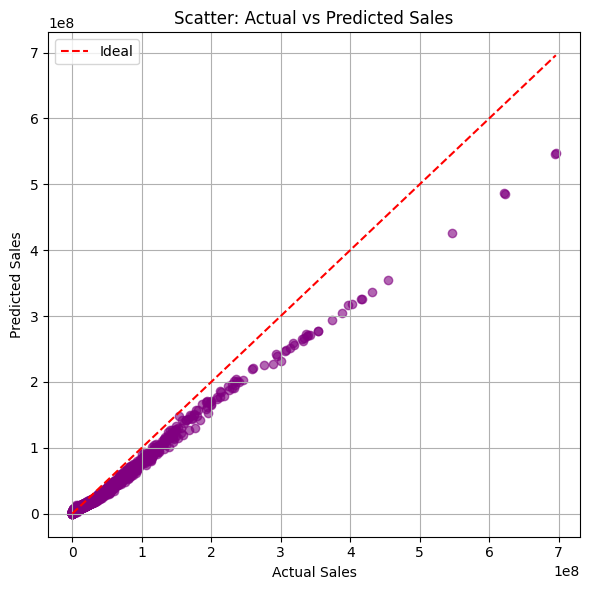

In [7]:
import matplotlib.pyplot as plt

def plot_preds_vs_actual(preds, targets, title="Predicted vs Actual Sales"):
    plt.figure(figsize=(6, 6))
    plt.scatter(test_targets, test_preds, alpha=0.6, color='purple')
    plt.plot([min(test_targets), max(test_targets)],
            [min(test_targets), max(test_targets)],
            'r--', label='Ideal')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Scatter: Actual vs Predicted Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_preds_vs_actual(test_preds, test_targets, title="Doanh thu thực tế so với doanh thu dự đoán")


Dự đoán doanh thu trong 30 ngày tiếp theo 

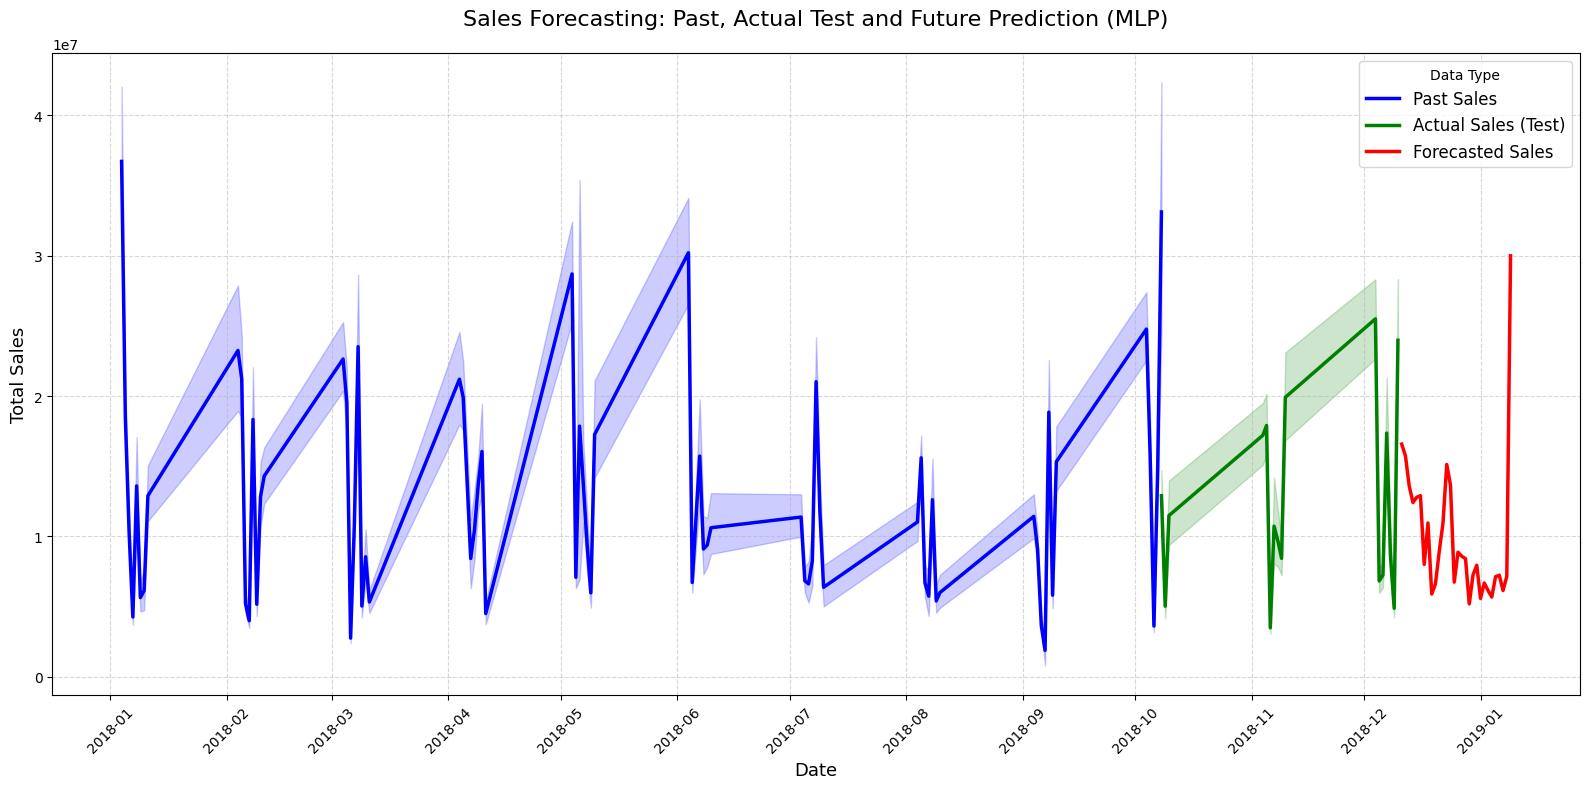

,Date,Predicted Sales
0,2018-12-11,16573239.0
1,2018-12-12,15736951.0
2,2018-12-13,13596473.0
3,2018-12-14,12407155.0
4,2018-12-15,12781935.0
5,2018-12-16,12895402.0
6,2018-12-17,8000814.5
7,2018-12-18,10947953.0
8,2018-12-19,5882472.0
9,2018-12-20,6615125.0


In [8]:
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# Lấy ngày cuối cùng trong tập test
last_date = pd.to_datetime(test_df['date'].iloc[-1])

# Tạo 30 ngày tiếp theo
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')

# Dữ liệu đầu vào cho dự đoán
future_X_raw = test_df[features].iloc[-30:].values
future_X_scaled = scaler_X.transform(future_X_raw)

# Dự đoán với mô hình MLP
model.eval()
with torch.no_grad():
    future_X_tensor = torch.tensor(future_X_scaled, dtype=torch.float32).to(device)
    future_preds_scaled = model(future_X_tensor).cpu().numpy().flatten()
    future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

# Tạo DataFrame chứa dự đoán
future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

# Chuẩn bị dữ liệu quá khứ để vẽ
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'

# Gộp tất cả để vẽ
combined_df = pd.concat([train_df, valid_df, test_df, future_df], ignore_index=True)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction (MLP)', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()

# Trả về DataFrame chứa dự đoán
future_df[['date', 'total_sales']].rename(columns={'date': 'Date', 'total_sales': 'Predicted Sales'})
